In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
import concurrent.futures
import pickle
warnings.filterwarnings('ignore', message='.*unary_union.*')

lodes = pd.read_csv("data/LODES.csv", low_memory=False)
census = pd.read_csv("data/Decennial_Census.csv")
shapes = gpd.read_file("data/tract_shapefiles/il_t_2020_bound.shp")

lodes["workplace_tract_code"] = lodes["workplace_block_code"].apply(lambda x: str(x)[:11])
lodes["home_tract_code"] = lodes["home_block_code"].apply(lambda x: str(x)[:11])

lodes.drop("Unnamed: 0", axis=1, inplace=True)
census.drop("Unnamed: 0", axis=1, inplace=True)
shapes = shapes[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'geometry']]
shapes = shapes.to_crs(epsg=3435)
census["tract_code"] = census["geo_id"].apply(lambda x: x[-11:])
census["population"] = census["white"] + census["black"] + census["asian"] + census["american_indian_alaska_native"] + census["pacific_islander"] + census["other_race"] + census["multiracial"] + census["hispanic_latino"]

In [ ]:
import torch
from torch import cuda
import random
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import networkx as nx
import numpy as np
import geopandas as gpd
from concurrent.futures import ProcessPoolExecutor, as_completed
from copy import deepcopy
import time

class ILRedistrictingCUDA:
    def __init__(self, census_df, shapes_df, lodes_df, n_districts=17):
        '''Initializes the redistricting object with CUDA support.'''
        self.device = torch.device('cuda' if cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.census = census_df.copy()
        self.shapes = shapes_df.copy()
        self.lodes = lodes_df.copy()
        self.n_districts = n_districts

        self.population_tensor = torch.tensor(
            self.census['population'].values, 
            device=self.device, 
            dtype=torch.float32
        )
        self.hispanic_tensor = torch.tensor(
            self.census['hispanic_latino'].values, 
            device=self.device, 
            dtype=torch.float32
        )
        self.black_tensor = torch.tensor(
            self.census['black'].values, 
            device=self.device, 
            dtype=torch.float32
        )

        self.data = self.census.merge(
            self.shapes[['GEOID20', 'geometry']], 
            left_on='tract_code', right_on='GEOID20', 
            how='left'
        ).drop(columns=['GEOID20'])
        
        self.data = gpd.GeoDataFrame(self.data, geometry='geometry')
        self.data.set_crs(epsg=3435, inplace=True)

        centroids = self.data.geometry.centroid
        self.centroid_x = torch.tensor(
            [c.x for c in centroids], 
            device=self.device, 
            dtype=torch.float32
        )
        self.centroid_y = torch.tensor(
            [c.y for c in centroids], 
            device=self.device, 
            dtype=torch.float32
        )

        self.block_to_idx = dict(zip(self.data['tract_code'], range(len(self.data))))
        self.graph = self._create_block_graph()

    def _create_block_graph(self):
        """Create the graph of neighboring census blocks."""
        graph = nx.Graph()
        for idx, row in self.data.iterrows():
            graph.add_node(row['tract_code'], geometry=row['geometry'])
        
        for idx, row in self.data.iterrows():
            possible_neighbors = self.data.sindex.query(row['geometry'], predicate='intersects')
            for neighbor_idx in possible_neighbors:
                if idx != neighbor_idx:
                    neighbor_geom = self.data.iloc[neighbor_idx]['geometry']
                    if row['geometry'].intersection(neighbor_geom).length > 0:
                        graph.add_edge(row['tract_code'], self.data.iloc[neighbor_idx]['tract_code'])
        return graph

    def _is_contiguous(self, district):
        """Check if a district is contiguous."""
        if not district:
            return False
        subgraph = self.graph.subgraph(district)
        return nx.is_connected(subgraph)

    def _initialize_lodes_scores(self, districts):
        """Compute initial LODES scores for all districts."""
        print("Calculating initial LODES scores.")
        lodes_scores = {}
        for district_idx, district in enumerate(districts):
            tracts = set(district)
            district_lodes = self.lodes[
                self.lodes['workplace_tract_code'].isin(tracts) |
                self.lodes['home_tract_code'].isin(tracts)
            ]

            total_live_in = district_lodes[district_lodes['home_tract_code'].isin(tracts)]['total_jobs'].sum()
            total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(tracts)]['total_jobs'].sum()
            live_and_work_in = district_lodes[
                (district_lodes['workplace_tract_code'].isin(tracts)) &
                (district_lodes['home_tract_code'].isin(tracts))
            ]['total_jobs'].sum()

            percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
            percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0

            district_score = (2 / 3 * percentage_live_and_work) + (1 / 3 * percentage_work_and_live)
            lodes_scores[district_idx] = district_score / 100

        print("Initial LODES scores calculated.")
        return lodes_scores

    def _generate_proposal(self, districts, lodes_scores, max_attempts=10):
        """Generate a new proposal by moving one tract between districts."""
        for attempt in range(max_attempts):
            print(f"Attempt {attempt + 1}/{max_attempts}: Generating proposal...")

            new_districts = [list(district) for district in districts]
            from_district_idx = random.randint(0, len(new_districts) - 1)
            from_district = new_districts[from_district_idx]
            
            if not from_district:
                continue

            eligible_tracts = []
            for tract in from_district:
                neighbors = list(self.graph.neighbors(tract))
                external_neighbors = sum(
                    1 for neighbor in neighbors if any(neighbor in d for d in new_districts if d != from_district)
                )
                eligible_tracts.extend([tract] * external_neighbors)

            if not eligible_tracts:
                continue

            tract_to_move = random.choice(eligible_tracts)
            if tract_to_move not in from_district:
                continue

            neighbors = list(self.graph.neighbors(tract_to_move))
            neighboring_districts = [
                idx for idx, district in enumerate(new_districts)
                if any(neighbor in district for neighbor in neighbors) and idx != from_district_idx
            ]

            if not neighboring_districts:
                continue

            to_district_idx = random.choice(neighboring_districts)
            from_district.remove(tract_to_move)
            new_districts[to_district_idx].append(tract_to_move)

            if self._is_contiguous(new_districts[from_district_idx]) and self._is_contiguous(new_districts[to_district_idx]):
                if all(self._is_contiguous(district) for district in new_districts):
                    print(f"Attempt {attempt + 1}: Successfully generated a valid proposal.")
                    return new_districts, tract_to_move, from_district_idx, to_district_idx, lodes_scores

            new_districts[to_district_idx].remove(tract_to_move)
            from_district.append(tract_to_move)

        print(f"Failed to generate a valid contiguous proposal after {max_attempts} attempts.")
        return None, None, None, None, None

    def _evaluate_proposal_incremental(self, proposal, tract_to_move, from_district_idx, to_district_idx, previous_scores):
        """Incrementally update LODES scores for affected districts."""
        if previous_scores is None:
            raise ValueError("previous_scores must not be None for incremental updates.")

        print(f"Updating LODES scores for districts {from_district_idx} and {to_district_idx}.")
        current_scores = deepcopy(previous_scores)

        from_district_tracts = set(proposal[from_district_idx])
        district_lodes = self.lodes[
            self.lodes['workplace_tract_code'].isin(from_district_tracts) |
            self.lodes['home_tract_code'].isin(from_district_tracts)
        ]
        
        total_live_in = district_lodes[district_lodes['home_tract_code'].isin(from_district_tracts)]['total_jobs'].sum()
        total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(from_district_tracts)]['total_jobs'].sum()
        live_and_work_in = district_lodes[
            (district_lodes['workplace_tract_code'].isin(from_district_tracts)) &
            (district_lodes['home_tract_code'].isin(from_district_tracts))
        ]['total_jobs'].sum()

        percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
        percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0
        current_scores[from_district_idx] = (2 / 3 * percentage_live_and_work + 1 / 3 * percentage_work_and_live) / 100

        to_district_tracts = set(proposal[to_district_idx])
        district_lodes = self.lodes[
            self.lodes['workplace_tract_code'].isin(to_district_tracts) |
            self.lodes['home_tract_code'].isin(to_district_tracts)
        ]
        
        total_live_in = district_lodes[district_lodes['home_tract_code'].isin(to_district_tracts)]['total_jobs'].sum()
        total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(to_district_tracts)]['total_jobs'].sum()
        live_and_work_in = district_lodes[
            (district_lodes['workplace_tract_code'].isin(to_district_tracts)) &
            (district_lodes['home_tract_code'].isin(to_district_tracts))
        ]['total_jobs'].sum()

        percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
        percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0
        current_scores[to_district_idx] = (2 / 3 * percentage_live_and_work + 1 / 3 * percentage_work_and_live) / 100

        return current_scores

    def _calculate_scores_cuda(self, proposal):
        """Calculate all scores using CUDA acceleration where possible."""

        compactness_distances = []
        for district in proposal:
            district_indices = torch.tensor(
                [self.block_to_idx[tract] for tract in district],
                device=self.device
            )
            
            district_populations = self.population_tensor[district_indices]
            district_centroids_x = self.centroid_x[district_indices]
            district_centroids_y = self.centroid_y[district_indices]
            
            total_population = district_populations.sum()
            
            if total_population.item() == 0:  #cpu scaler
                compactness_distances.append(float('inf'))
                continue
            
            x_center = (district_centroids_x * district_populations).sum() / total_population
            y_center = (district_centroids_y * district_populations).sum() / total_population
            
            distances = torch.sqrt(
                (district_centroids_x - x_center)**2 + 
                (district_centroids_y - y_center)**2
            )
            mean_squared_distance = (distances**2 * district_populations).sum() / total_population
            compactness_distances.append(mean_squared_distance.cpu().item())  #cpu scaler
        
        max_reasonable_distance = 100000
        compactness_score = 1 - torch.tensor(
            [min(d, max_reasonable_distance) / max_reasonable_distance 
             for d in compactness_distances],
            device=self.device
        ).mean().cpu().item()  #cpu scaler

        # Population Score
        district_populations = torch.zeros(len(proposal), device=self.device)
        for i, district in enumerate(proposal):
            district_indices = torch.tensor(
                [self.block_to_idx[tract] for tract in district],
                device=self.device
            )
            district_populations[i] = self.population_tensor[district_indices].sum()

        target_population = district_populations.mean()
        relative_deviations = torch.abs(district_populations - target_population) / target_population

        # Apply fourth-power penalty to deviations
        weighted_deviations = relative_deviations ** 4

        # Compute population score
        population_score = (1 - weighted_deviations.mean()).cpu().item()# Convert to CPU scalar

        # VRA Score
        district_hispanic = torch.zeros(len(proposal), device=self.device)
        district_black = torch.zeros(len(proposal), device=self.device)
        
        for i, district in enumerate(proposal):
            district_indices = torch.tensor(
                [self.block_to_idx[tract] for tract in district],
                device=self.device
            )
            district_hispanic[i] = self.hispanic_tensor[district_indices].sum()# Convert to CPU scalar
            district_black[i] = self.black_tensor[district_indices].sum()# Convert to CPU scalar
        
        hispanic_percentages = district_hispanic / district_populations
        black_percentages = district_black / district_populations
        
        target_majority_districts = 2
        hispanic_majority = (hispanic_percentages > 0.5).sum().cpu().item()  
        black_majority = (black_percentages > 0.5).sum().cpu().item() 
        
        vra_score = (min(hispanic_majority, target_majority_districts) + 
                    min(black_majority, target_majority_districts)) / (2 * target_majority_districts)

        return compactness_score, population_score, vra_score

    def _evaluate_proposal(self, proposal, lodes_scores=None, tract_to_move=None, 
                         from_district_idx=None, to_district_idx=None, weights=None):
        """Evaluate proposal using CUDA-accelerated calculations where possible."""
        if weights is None:
            weights = {
                'compactness': 1.0,
                'community': 1.0,
                'population': 1.0,
                'vra': 1.0
            }

        # Get CUDA-accelerated scores (returns CPU scalars)
        compactness_score, population_score, vra_score = self._calculate_scores_cuda(proposal)

        # Get community preservation score
        if tract_to_move is not None and from_district_idx is not None and to_district_idx is not None:
            lodes_scores = self._evaluate_proposal_incremental(
                proposal, tract_to_move, from_district_idx, to_district_idx, lodes_scores
            )
        elif lodes_scores is None:
            raise ValueError("LODES scores must not be None during the initial evaluation.")

        community_score = np.mean(list(lodes_scores.values()))

        # Calculate weighted total score (all values are now CPU scalars)
        total_score = (
            weights['compactness'] * compactness_score +
            weights['community'] * community_score +
            weights['population'] * population_score +
            weights['vra'] * vra_score
        ) / sum(weights.values())

        print(
            f"Compactness: {compactness_score:.4f}, "
            f"Community Preservation: {community_score:.4f}, "
            f"Population Parity: {population_score:.4f}, "
            f"VRA Score: {vra_score:.4f}, "
            f"Total Score: {total_score:.4f}"
        )

        return total_score, compactness_score, community_score, population_score, vra_score

    def _initialize_random_districts(self):
        """Generate initial districts using flood-fill approach."""
        while True:
            total_population = self.population_tensor.sum().item()
            target_population = total_population / self.n_districts

            unassigned_blocks = set(self.data['tract_code'])
            block_populations = {
                tract: pop.item() for tract, pop in 
                zip(self.data['tract_code'], self.population_tensor)
            }
            districts = [[] for _ in range(self.n_districts)]
            district_populations = [0] * self.n_districts

            for district_idx in range(self.n_districts):
                if not unassigned_blocks:
                    break

                seed_block = random.choice(list(unassigned_blocks))
                queue = [seed_block]

                while queue:
                    block = queue.pop(0)

                    if block not in unassigned_blocks:
                        continue
                    if district_populations[district_idx] + block_populations[block] > target_population * 1.1:
                        continue

                    districts[district_idx].append(block)
                    district_populations[district_idx] += block_populations[block]
                    unassigned_blocks.remove(block)

                    neighbors = list(self.graph.neighbors(block))
                    for neighbor in neighbors:
                        if neighbor in unassigned_blocks:
                            queue.append(neighbor)

            # Handle remaining unassigned blocks
            for block in unassigned_blocks:
                best_district = None
                max_neighbors = -1

                neighbors = list(self.graph.neighbors(block))
                for district_idx, district in enumerate(districts):
                    neighbor_count = sum(1 for neighbor in neighbors if neighbor in district)
                    if neighbor_count > max_neighbors:
                        max_neighbors = neighbor_count
                        best_district = district_idx

                if best_district is not None:
                    districts[best_district].append(block)
                    district_populations[best_district] += block_populations[block]
                else:
                    min_population_idx = district_populations.index(min(district_populations))
                    districts[min_population_idx].append(block)
                    district_populations[min_population_idx] += block_populations[block]

            # Handle underpopulated districts
            underpopulated_threshold = 0.2 * target_population
            donor_threshold = 0.4 * target_population
            attempts = {}

            for idx, district in enumerate(districts):
                while district_populations[idx] < underpopulated_threshold:
                    print(f"District {idx} has population below 20% of target. Redistributing neighbors.")

                    neighbors = set(
                        neighbor for block in district
                        for neighbor in self.graph.neighbors(block)
                    )
                    if idx not in attempts:
                        attempts[idx] = set()

                    transferred = False
                    for neighbor in neighbors:
                        if neighbor in attempts[idx]:
                            continue

                        donor_idx = next(
                            (i for i, d in enumerate(districts) if neighbor in d), None
                        )
                        if donor_idx is not None and donor_idx != idx and district_populations[donor_idx] > donor_threshold:
                            districts[donor_idx].remove(neighbor)
                            districts[idx].append(neighbor)
                            district_populations[donor_idx] -= block_populations[neighbor]
                            district_populations[idx] += block_populations[neighbor]

                            if self._is_contiguous(districts[idx]) and self._is_contiguous(districts[donor_idx]):
                                transferred = True
                                print(f"Transferred block {neighbor} from District {donor_idx} to District {idx}.")
                                break
                            else:
                                districts[idx].remove(neighbor)
                                districts[donor_idx].append(neighbor)
                                district_populations[donor_idx] += block_populations[neighbor]
                                district_populations[idx] -= block_populations[neighbor]
                                attempts[idx].add(neighbor)

                    if not transferred:
                        print(f"Warning: Unable to fully populate district {idx}. Moving to next district.")
                        break

            if all(self._is_contiguous(district) for district in districts):
                return districts
            else:
                print("Contiguity issues detected in final validation. Restarting generation...")

    def mcmc(self, phase1_iterations=10000, phase2_iterations=15000, phase3_iterations=10000):
        """Run three-phase MCMC optimization with CUDA acceleration."""
        districts = self._initialize_random_districts()
        districts_initial = deepcopy(districts)
        total_iterations = phase1_iterations + phase2_iterations + phase3_iterations
        
        scores_log = {
            "iteration": [],
            "phase": [],
            "total_score": [],
            "compactness": [],
            "community_preservation": [],
            "population_parity": [],
            "vra_score": [],
            "temperature": [],
        }
        
        lodes_scores = self._initialize_lodes_scores(districts)
        best_districts = deepcopy(districts)
        best_score, _, _, _, _ = self._evaluate_proposal(districts, lodes_scores)
        
        def get_weights(iteration):
            if iteration < phase1_iterations:
                return {
                    'compactness': 2.0,
                    'community': 0.2,
                    'population': 3.0,
                    'vra': 0.5
                }
            elif iteration < (phase1_iterations + phase2_iterations):
                phase2_progress = (iteration - phase1_iterations) / phase2_iterations
                compactness_weight = max(0.1, 2.0 * (1 - phase2_progress))
                return {
                    'compactness': compactness_weight,
                    'community': 2.0,
                    'population': 1.5,
                    'vra': 2.0
                }
            else:
                return {
                    'compactness': 1.5,
                    'community': 1.0,
                    'population': 2.0,
                    'vra': 2.0
                }
        
        def get_temperature(iteration):
            if iteration < phase1_iterations:
                progress = iteration / phase1_iterations
                T_initial_1, T_final_1 = 0.1, 0.01
                return T_initial_1 * ((T_final_1 / T_initial_1) ** progress)
            elif iteration < (phase1_iterations + phase2_iterations):
                progress = (iteration - phase1_iterations) / phase2_iterations
                T_initial_2, T_final_2 = 0.08, 0.008
                return T_initial_2 * ((T_final_2 / T_initial_2) ** progress)
            else:
                progress = (iteration - (phase1_iterations + phase2_iterations)) / phase3_iterations
                T_initial_3, T_final_3 = 0.05, 0.005
                return T_initial_3 * ((T_final_3 / T_initial_3) ** progress)
        
        try:
            for iteration in range(total_iterations):
                current_phase = 1 if iteration < phase1_iterations else 2 if iteration < phase1_iterations + phase2_iterations else 3
                print(f"Iteration {iteration}: Phase {current_phase}")
                
                new_districts, tract_to_move, from_district_idx, to_district_idx, _ = self._generate_proposal(
                    districts, lodes_scores
                )
                
                if new_districts is None:
                    print(f"Iteration {iteration}: Proposal generation failed. Skipping.")
                    continue
                
                lodes_scores = self._evaluate_proposal_incremental(
                    new_districts, tract_to_move, from_district_idx, to_district_idx, lodes_scores
                )
                
                current_weights = get_weights(iteration)
                new_score, compactness, community_preservation, population_parity, vra_score = self._evaluate_proposal(
                    new_districts, lodes_scores, weights=current_weights
                )
                
                T = get_temperature(iteration)
                
                scores_log["iteration"].append(iteration)
                scores_log["phase"].append(current_phase)
                scores_log["total_score"].append(new_score)
                scores_log["compactness"].append(compactness)
                scores_log["community_preservation"].append(community_preservation)
                scores_log["population_parity"].append(population_parity)
                scores_log["vra_score"].append(vra_score)
                scores_log["temperature"].append(T)
                
                if new_score > best_score:
                    best_districts = deepcopy(new_districts)
                    best_score = new_score
                    print(f"Iteration {iteration}: New best score {best_score:.4f}")
                
                if new_score > best_score or random.uniform(0, 1) < np.exp((new_score - best_score)/T):
                    districts = new_districts
                    print(f"Proposal accepted. Temperature: {T:.6f}")
                
                if iteration == phase1_iterations - 1:
                    print("Transitioning to Phase 2: Community and VRA focus")
                elif iteration == phase1_iterations + phase2_iterations - 1:
                    print("Transitioning to Phase 3: Legal compliance focus")

        finally:
            # Clean up CUDA memory
            torch.cuda.empty_cache()
        
        return best_districts, districts_initial, scores_log

In [14]:
il_redistricting = ILRedistrictingCUDA(census, shapes, lodes, n_districts=17)

Using device: cuda


In [23]:
optimal_districts, districtsinitial, scores_log = il_redistricting.mcmc(
        phase1_iterations=1000,
        phase2_iterations=1500,
        phase3_iterations=1000
    )

District 3 has population below 20% of target. Redistributing neighbors.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167000202 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167002900 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167003902 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167003000 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167004000 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167002400 from District 7 to District 9.
District 9 has population below 20% of target. Redistributing neighbors.
Transferred block 17167000201 from District 7 to D

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_scores(scores_log):
    scores_df = pd.DataFrame(scores_log)
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    scores_df.plot(
        x='iteration',
        y=['total_score', 'compactness', 'community_preservation', 
           'population_parity', 'vra_score'],
        ax=axes[0]
    )
    axes[0].set_title('Score Components Over Time')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Score')
    axes[0].axvline(x=10000, color='r', linestyle='--', label='Phase 1 End')
    axes[0].axvline(x=25000, color='g', linestyle='--', label='Phase 2 End')
    axes[0].legend()
    
    axes[1].plot(scores_df['iteration'], scores_df['temperature'])
    axes[1].set_title('Temperature Schedule')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Temperature')
    axes[1].set_yscale('log')
    
    sns.scatterplot(
        data=scores_df,
        x='compactness',
        y='community_preservation',
        hue='phase',
        ax=axes[2],
        alpha=0.5
    )
    axes[2].set_title('Compactness vs Community Preservation by Phase')
    
    plt.tight_layout()
    plt.show()

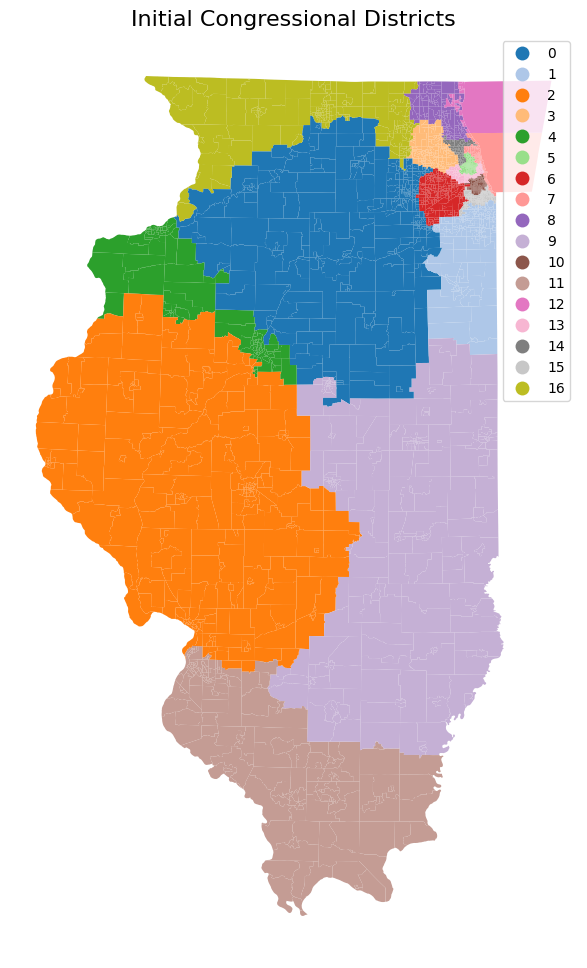

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(districtsinitial):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Initial Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


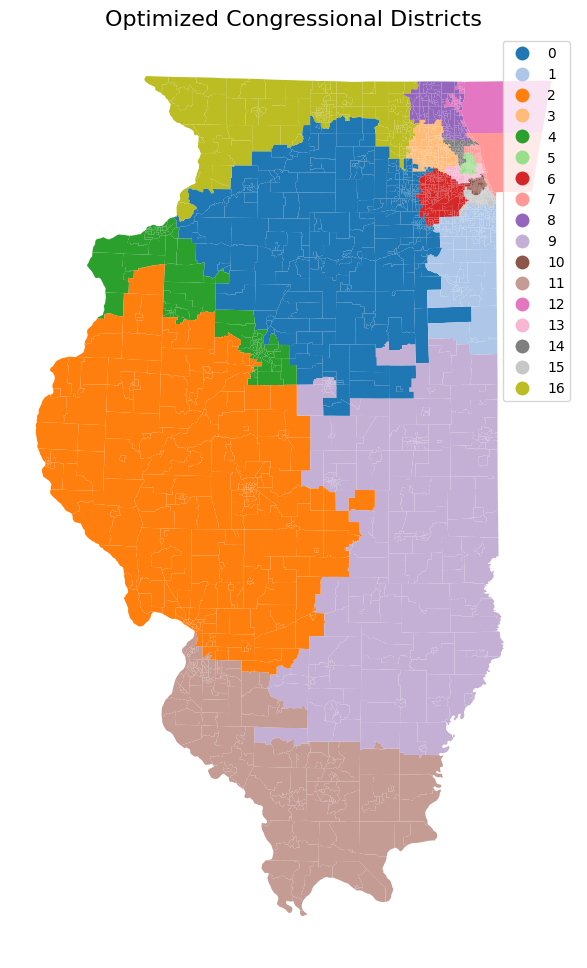

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(optimal_districts):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Optimized Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

def calculate_district_populations(districts, data):
    return [
        sum(data[data['tract_code'].isin(district)]['population'])
        for district in districts
    ]

initial_populations = calculate_district_populations(districtsinitial, il_redistricting.data)
optimized_populations = calculate_district_populations(optimal_districts, il_redistricting.data)

plt.figure(figsize=(10, 6))
plt.plot(initial_populations, label="Initial Districts", marker='o')
plt.plot(optimized_populations, label="Optimized Districts", marker='x')
plt.axhline(
    il_redistricting.data['population'].sum() / il_redistricting.n_districts,
    color='gray', linestyle='--', label="Target Population"
)

plt.title("District Populations: Initial vs Optimized")
plt.xlabel("District Index")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'districtsinitial' is not defined